In [1]:
import os
import hashlib
from pathlib import Path
import argparse

import torch
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import BasePredictionWriter
import pandas as pd
import lightning.pytorch as pl
from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule

import numpy as np
import multiscale_phate
import scprep
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import wandb


## Notebook Params

In [2]:
##########################################################################################
# Set up environment and parser
##########################################################################################

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.set_float32_matmul_precision('medium')


from dataclasses import dataclass
@dataclass
class EmbeddingArgs:
    model: str
    channels: str
    data: str
args = EmbeddingArgs(
    # model="/data/ishang/fucci_vae/fucci_256_512_2023_05_24_05_47/", # dummy model!!!
    # channels="fucci",
    model="/data/ishang/fucci_vae/FUCCI_reference_VAE_2023_06_06_22_45/",
    channels="reference",
    data="/data/ishang/Fucci-dataset-v3_filtered/")
    # data="/home/ishang/implicit-cell-model/FUCCI-dev-data")

devices = 8
perm = (1, 0)

flipped = False

view_variance = True

# Note that the index.csv might not be right, but we don't need it right now

if not Path(args.model).exists():
    raise ValueError("Checkpoint path does not exist.")
args.model = Path(args.model)
if not args.model.is_file():
    if args.model / "lightning_logs" in args.model.iterdir():
        args.model = args.model / "lightning_logs"
        if len(list(args.model.iterdir())) > 1:
            raise ValueError("Multiple model directories were found in lightning_logs.")
        else:
            args.model = list(args.model.iterdir())[0]
    else:
        raise ValueError("Model path does not contain lightning_logs directory.")

if not Path(args.data).exists():
    raise ValueError("Data path does not exist.")
args.data = Path(args.data)

if args.channels not in ["reference", "fucci", "total"]:
    raise ValueError("Model must be one of: reference, fucci, total")

if args.channels == "total":
    raise NotImplementedError("Total channels not trained yet.")


def img_hash(image):
    return hashlib.blake2b(image.numpy().tobytes()).hexdigest()


mu_file = args.data / (f"{args.channels}_mu" + ("flipped" if flipped else "") + ".pt")
var_file = args.data / (f"{args.channels}_var" + ("flipped" if flipped else "") + ".pt")
indices_file = args.data / (f"{args.channels}_indices" + ("flipped" if flipped else ""))
colors_file = args.data / "colors"

## Data Setup

In [3]:
# retrieve the index file for the dataset if it exists--this index is wrong though since 
# it doesn't get overwritten with the specific channels you're loading


if args.data / "index.csv" not in args.data.iterdir():
    if args.channels == "reference":
        dataset = ReferenceChannelDatasetInMemory(args.data, imsize=256)
    elif args.channels == "fucci":
        dataset = FUCCIChannelDatasetInMemory(args.data, imsize=256)
    else:
        dataset = FUCCIDatasetInMemory(args.data, imsize=256)
    cache = []
    for i in range(len(dataset)):
        exp_dir, cell_index = dataset.image_exp_index(i)
        cache.append({
            "index": i,
            "hash": img_hash(dataset[i]),
            "directory": str(exp_dir[1]),
            "cell_index": cell_index
        })
    cache = pd.DataFrame(cache)
    cache.to_csv(args.data / "index.csv")

else:
    cache = pd.read_csv(args.data / "index.csv")

In [4]:
# Load model and datamodule
model = AutoEncoder.load_from_checkpoint(args.model)

# Need to also use the commandline restore code functionality to use this.
# project = "FUCCI_reference_VAE" if args.channels == "reference" else "FUCCI_fucci_VAE"
# run_id = "nryo25e4" if args.channels == "reference" else "vwipkcy0"
# checkpoint = "lundberg-lab/" + project + "/" + run_id + ":best"

# # download checkpoint locally (if not already cached)
# run = wandb.init(project=project)
# artifact = run.use_artifact(checkpoint, type="model")
# artifact_dir = artifact.download()

# # load checkpoint
# model = AutoEncoder.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")

In [6]:
dm = FUCCIDataModule(args.data, args.channels, imsize=256, batch_size=16, num_workers=8, in_memory=True)

## Cache embeddings

In [7]:
predict_dm = dm

In [8]:
class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))


pred_writer = CustomWriter(output_dir=args.data, write_interval="epoch")

In [9]:
# run trainer on data and store predictions in the .pt files above

trainer = pl.Trainer(accelerator="gpu", devices=devices, callbacks=[pred_writer])
model.set_predict_mode("embedding")
trainer.predict(model, datamodule=predict_dm, return_predictions=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/8
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/8
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/8
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/8
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/8
Initializing distributed: GLOBAL_RANK: 6, MEMBER: 7/8
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/8
Initializing distributed: GLOBAL_RANK: 7, MEMBER: 8/8
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 8 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 5 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 

Predicting: 0it [00:00, ?it/s]

In [10]:
# predictions are a list of tensors, each tensor is the predictions of a batch
# batch_indices are is a list of list of lists, each list of lists is the batch indices of an epoch
# for prediction we will only have one epoch, so we only need the first list of lists

predictions = []
batch_indices = []
for i in range(devices):
    predictions.append(torch.load(args.data / f"predictions_{i}.pt"))
    batch_indices.append(torch.load(args.data / f"batch_indices_{i}.pt")[0])

def flatten_one(l):
    return [item for sublist in l for item in sublist]

print(len(predictions))
print(len(batch_indices))
# embeddings = []
# for batch in predictions:
#     embeddings.append(batch[1])
# embeddings = flatten_one(embeddings)
# batch_indices = flatten_one(batch_indices)
# print(len(embeddings))
# print(len(batch_indices))

8
8


In [11]:
predictions = flatten_one(predictions)
batch_indices = flatten_one(batch_indices)
print(len(predictions))
print(len(batch_indices))

3488
3488


In [12]:
mu = []
var = []
for i in range(len(predictions)):
    mu.append(predictions[i][0])
    var.append(predictions[i][1])

In [13]:
mu = torch.cat(mu)
var = torch.cat(var)
indices = flatten_one(batch_indices)
print(mu.shape, var.shape, len(indices))

torch.Size([55777, 512]) torch.Size([55777, 512]) 55777


In [14]:
print(mu.min(), mu.max())
print(var.min(), var.max())
# print(torch.any(torch.isnan(logvar)))
# print(torch.any(torch.isinf(logvar)))
# logvar[torch.isinf(logvar)] = torch.finfo(logvar.dtype).max
# plt.clf()
# plt.hist(torch.log(logvar).cpu().numpy(), bins=100, log=True)
# # plt.xscale("log")
# # plt.yscale("log")
# plt.show()

tensor(-187.0561) tensor(166.7893)
tensor(0.) tensor(0.)


In [15]:
torch.save(mu, mu_file)
torch.save(var, var_file)
np.save(indices_file, np.asarray(indices))

In [16]:
# remove the batch_indices_*.pt and predictions_*.pt files
for i in range(devices):
    os.remove(args.data / f"predictions_{i}.pt")
    os.remove(args.data / f"batch_indices_{i}.pt")

(55777, 4, 256, 256)
-0.99749386 1.0


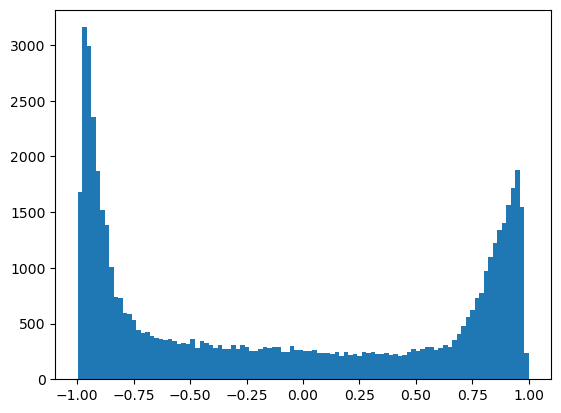

<Figure size 640x480 with 0 Axes>

In [18]:
# compute original colors
dataset = FUCCIDatasetInMemory(args.data, imsize=256)
colors = dataset[:].numpy()
print(colors.shape)
colors = colors[:, 2:, :, :]
colors = np.sum(colors[:, 0, :, :] - colors[:, 1, :, :], axis=(1, 2)) / np.sum(colors, axis=(1, 2, 3))
# colors = np.sign(colors) * np.log(np.abs(colors) + 1e-8)
print(colors.min(), colors.max())

plt.clf()
plt.hist(colors, bins=100)
plt.show()
plt.clf()

In [19]:
np.save(colors_file, colors)

## Analysis

In [20]:
mu = torch.load(mu_file)
var = torch.load(var_file)
indices = np.load(indices_file.with_suffix(".npy"))
colors = np.load(colors_file.with_suffix(".npy"))
# Update the cache file maybe? Maybe order the predictions or something so you don't need an indices file?--but just added no_shuffle to the datamodule so maybe not

In [21]:
input_entity = mu

In [22]:
print(input_entity.mean(), input_entity.std())

tensor(-0.2738) tensor(10.8707)


In [23]:
def PCA_plot(predictions, message="", sample=None):
    # select random elements and do PCA
    if sample is None:
        sample = len(predictions)
    indices = np.random.choice(len(predictions), sample)
    embeddings_slice = predictions[indices, :].numpy()
    num_components = embeddings_slice.shape[1]
    print(f"Using {num_components} components for PCA")
    pca = PCA(n_components=num_components)
    pca.fit(embeddings_slice)
    # print(pca.explained_variance_ratio_[:10])
    # print(pca.singular_values_)
    # print(pca.components_.shape)
    # print the number of components needed to have 95% of the variance
    print(f"Number of components needed to have 95% of the variance: {1+np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)}")

    # plot the first 2 components
    plt.clf()
    plt.title(f"PCA of FUCCI {args.channels} embeddings {message}")
    plt.scatter(pca.components_[0], pca.components_[1])
    plt.show()

    plt.clf()
    fig, ax = plt.subplots()
    plt.title(f"Bar chart of FUCCI {args.channels} PCA components CDF {message}")
    plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
    ax.axhline(y=0.95, color='r')
    plt.show()
    return pca

Using 512 components for PCA
Number of components needed to have 95% of the variance: 141


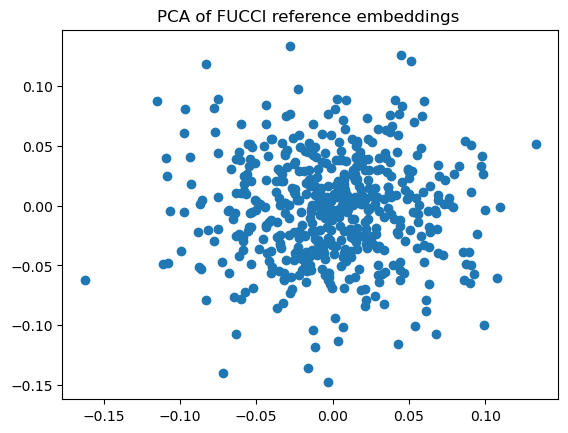

<Figure size 640x480 with 0 Axes>

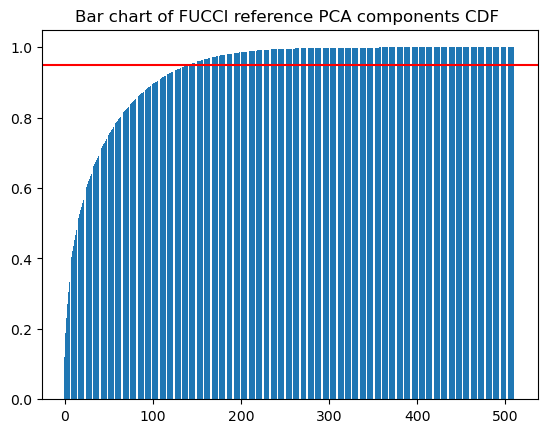

In [24]:
pca = PCA_plot(input_entity, message="")

In [25]:
def PHATE_fit(embeddings, sample=None, message=""):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    if sample is not None:
        indices = np.random.choice(len(embeddings), sample)
        embeddings = embeddings[indices]
    mp_op = multiscale_phate.Multiscale_PHATE()
    return mp_op.fit_transform(embeddings)

def PHATE_plot(mp_embedding, mp_sizes, mp_clusters, message=""):
    scprep.plot.scatter2d(mp_embedding, s=mp_sizes, c=mp_clusters,
                          fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10, 10))

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.11 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 2261 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


  Calculated diffusion potential in 11.10 seconds.
  Setting epsilon to 0.3734
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 20.72 seconds.
Calculated Multiscale PHATE tree in 33.21 seconds.
Computing gradient...
Identifying salient levels of resolution...


<Axes: xlabel='Multiscale PHATE1', ylabel='Multiscale PHATE2'>

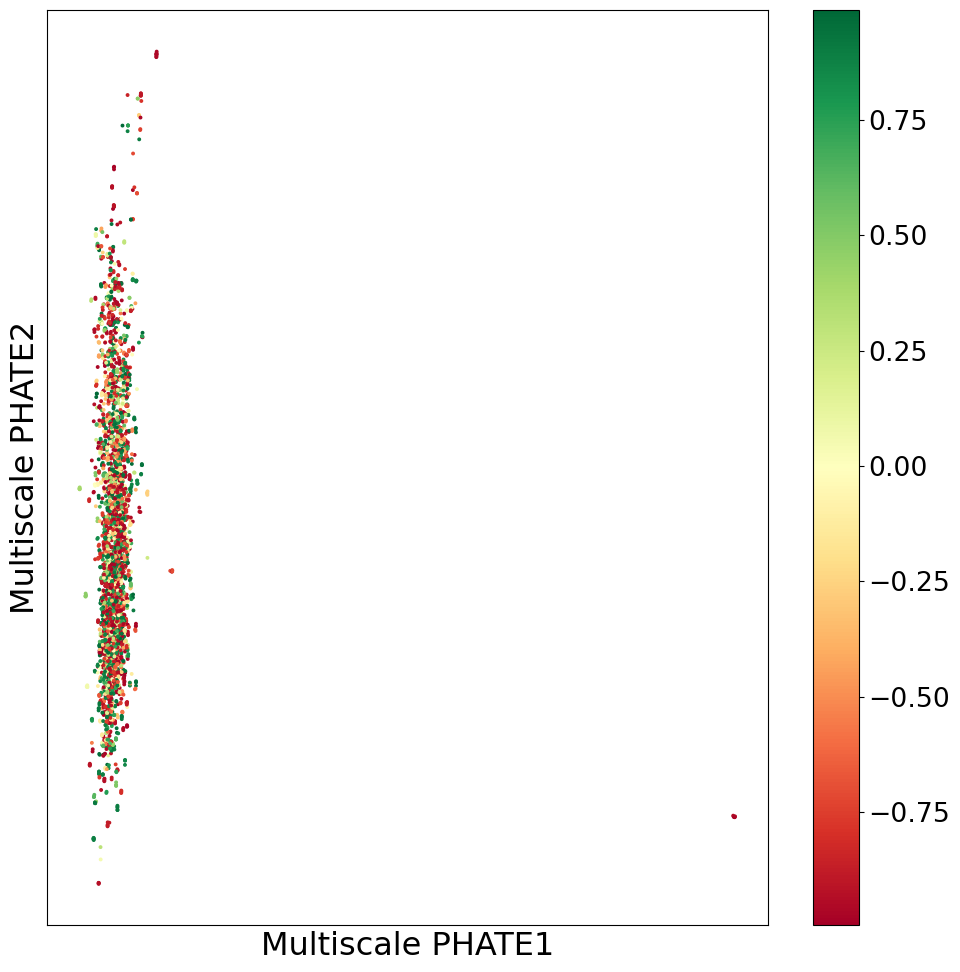

In [26]:
# script to compute PHATE levels, get embeddings separately, and add colors
# can pull this from the github
mp_op = multiscale_phate.Multiscale_PHATE()
indices = np.random.choice(len(predictions), 4000)
embeddings_slice = input_entity[indices, :].numpy()
colors_slice = colors[indices]
levels = mp_op.fit(embeddings_slice)
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = levels[0],
                                                                  cluster_level = levels[0])
scprep.plot.scatter2d(mp_embedding, cmap="RdYlGn", c=colors_slice, fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(10,10))

In [38]:
phate_output = PHATE_fit(input_entity, sample=1000)

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 0.06 seconds.
  Calculating diffusion potential...


/home/ishang/.local/lib/python3.10/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 155 and 461, 215 and 976, 348 and 485, 453 and 770, 614 and 680, 744 and 772, 808 and 876. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated diffusion potential in 0.72 seconds.
  Setting epsilon to 0.2608
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 1.68 seconds.
Calculated Multiscale PHATE tree in 2.47 seconds.
Computing gradient...
Identifying salient levels of resolution...


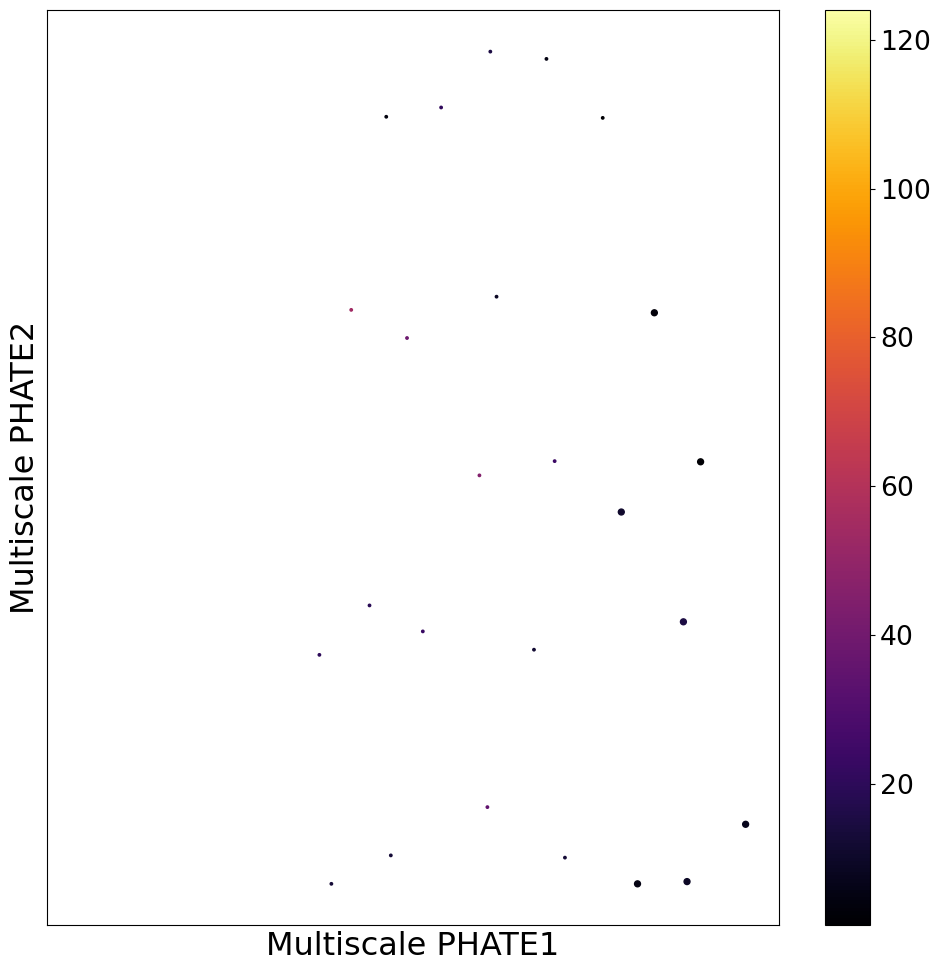

In [39]:
PHATE_plot(*phate_output, message="")

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packag

<Axes: >

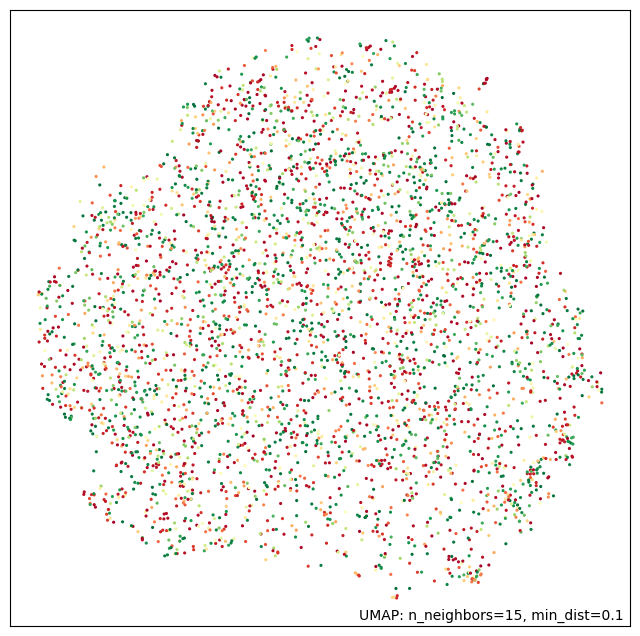

In [27]:
# plot UMAP of 100 samples

import umap
import umap.plot

indices = np.random.choice(len(input_entity), 4000)
embeddings_slice = input_entity[indices, :].numpy()
colors_slice = colors[indices]
umap_embedding = umap.UMAP().fit(embeddings_slice)
# umap.plot.points(umap_embedding)

# plot gradient of red to green for small to large
umap.plot.points(umap_embedding, values=colors_slice, cmap="RdYlGn")

(4000, 512)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


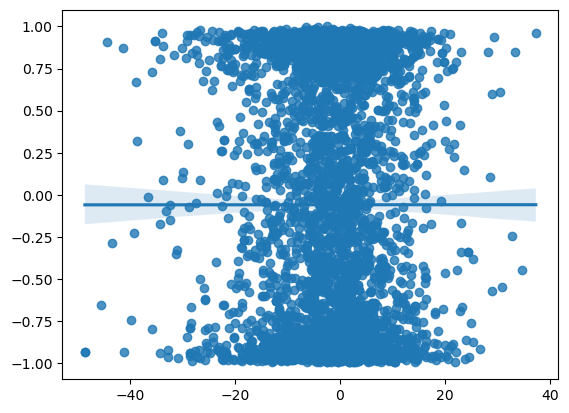

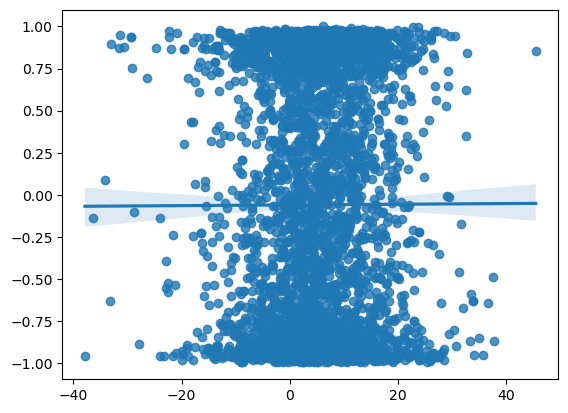

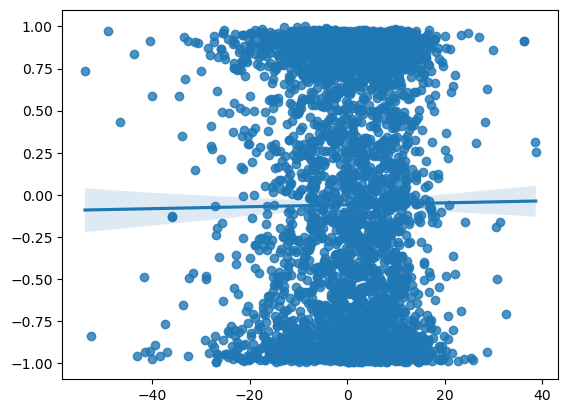

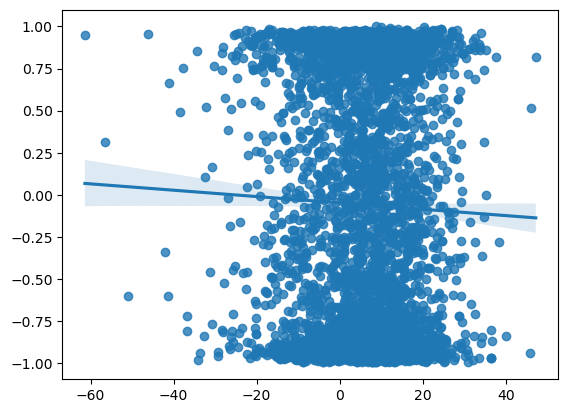

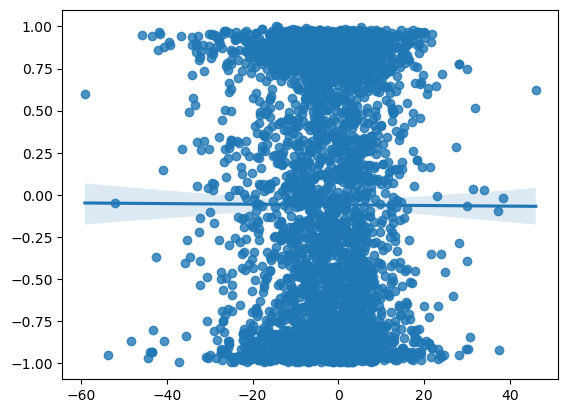

In [28]:
# Plot each variable in the embedding vector against the color and give the R^2 value of the correlation
import seaborn as sns

print(embeddings_slice.shape)
print(type(embeddings_slice), type(colors_slice))
num_points = 100
for i in range(5):
    plt.clf()
    fig = sns.regplot(x=embeddings_slice[:, i],
                y=colors_slice)
    plt.show()


(512, 512)
(4000, 512)
(512, 4000)


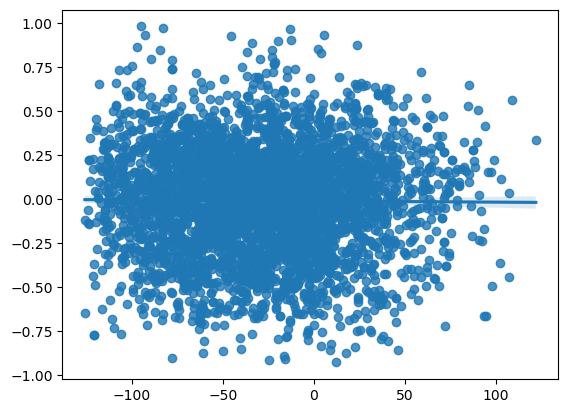

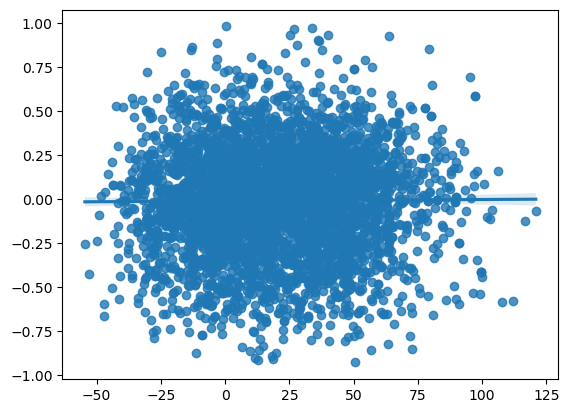

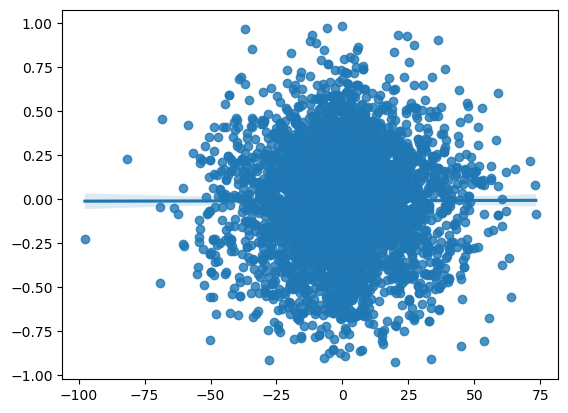

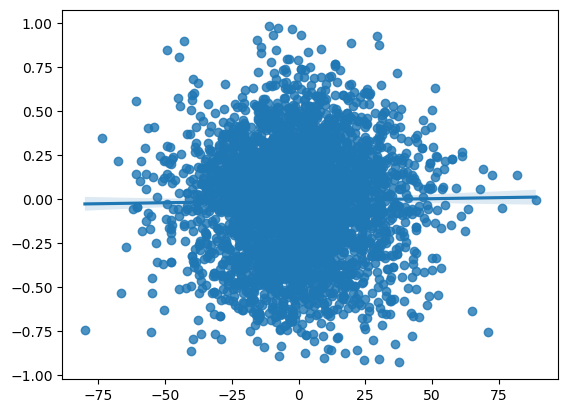

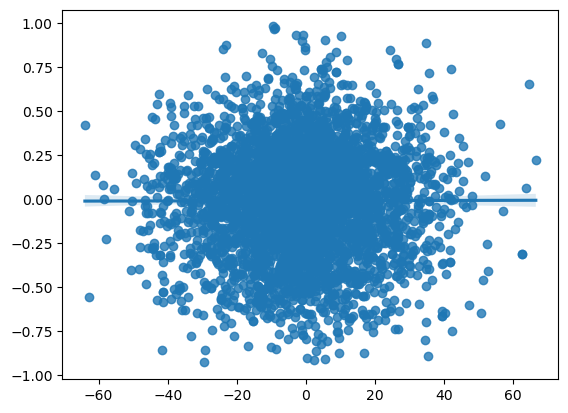

In [14]:
print(pca.components_.shape)
print(embeddings_slice.shape)
pc_embeddings = np.matmul(pca.components_, embeddings_slice.T)
print(pc_embeddings.shape)

num_points = 100
for i in range(5):
    plt.clf()
    fig = sns.regplot(x=pc_embeddings[i], y=colors_slice)
    plt.show()


In [16]:
# linear regression classifier over the pc_embeddings
from sklearn.linear_model import LinearRegression
# print(pc_embeddings.shape, colors.shape)
reg = LinearRegression().fit(pc_embeddings.T[:800, :10], colors_slice[:800])


In [17]:
print(reg.score(pc_embeddings.T[800:, :10], colors_slice[800:]))
print(reg.coef_)

-0.002218527616654864
[-5.1505947e-05 -7.8951794e-05 -2.5303496e-04  5.6590367e-04
  5.3998265e-05  6.6155283e-04  4.0002842e-04 -5.1810708e-05
  2.0068721e-03  2.7457299e-04]


In [15]:
# train logistic regression classifier on binarized colors
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter=1000)
reg.fit(pc_embeddings.T[:800, :10], colors_slice[:800] > 0)
print(reg.score(pc_embeddings.T[800:, :10], colors_slice[800:] > 0))

0.516875
